In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from tqdm import tqdm

import eitest

# Data generators

In [2]:
@numba.njit
def event_series_bernoulli(series_length, event_count):
    '''Generate an iid Bernoulli distributed event series.

    series_length: length of the event series
    event_count: number of events'''

    event_series = np.zeros(series_length)
    event_series[np.random.choice(np.arange(0, series_length), event_count, replace=False)] = 1
    return event_series

@numba.njit
def time_series_mean_impact(event_series, order, signal_to_noise):
    '''Generate a time series with impacts in mean as described in the paper.

    The impact weights are sampled iid from N(0, signal_to_noise),
    and additional noise is sampled iid from N(0,1). The detection problem will
    be harder than in time_series_meanconst_impact for small orders, as for small
    orders we have a low probability to sample at least one impact weight with a
    high magnitude. On the other hand, since the impact is different at every lag,
    we can detect the impacts even if the order is larger than the max_lag value
    used in the test.
    
    event_series: input of shape (T,) with event occurrences
    order: order of the event impacts
    signal_to_noise: signal to noise ratio of the event impacts'''

    series_length = len(event_series)
    weights = np.random.randn(order)*np.sqrt(signal_to_noise)
    time_series = np.random.randn(series_length)
    for t in range(series_length):
        if event_series[t] == 1:
            time_series[t+1:t+order+1] += weights[:order-max(0, (t+order+1)-series_length)]
    return time_series

@numba.njit
def time_series_meanconst_impact(event_series, order, const):
    '''Generate a time series with impacts in mean by adding a constant.
    Better for comparing performance across different impact orders, since the
    magnitude of the impact will always be the same.

    event_series: input of shape (T,) with event occurrences
    order: order of the event impacts
    const: constant for mean shift'''

    series_length = len(event_series)
    time_series = np.random.randn(series_length)
    for t in range(series_length):
        if event_series[t] == 1:
            time_series[t+1:t+order+1] += const
    return time_series

@numba.njit
def time_series_var_impact(event_series, order, variance):
    '''Generate a time series with impacts in variance as described in the paper.

    event_series: input of shape (T,) with event occurrences
    order: order of the event impacts
    variance: variance under event impacts'''

    series_length = len(event_series)
    time_series = np.random.randn(series_length)
    for t in range(series_length):
        if event_series[t] == 1:
            for tt in range(t+1, min(series_length, t+order+1)):
                time_series[tt] = np.random.randn()*np.sqrt(variance)
    return time_series

@numba.njit
def time_series_tail_impact(event_series, order, dof):
    '''Generate a time series with impacts in tails as described in the paper.

    event_series: input of shape (T,) with event occurrences
    order: delay of the event impacts
    dof: degrees of freedom of the t distribution'''

    series_length = len(event_series)
    time_series = np.random.randn(series_length)*np.sqrt(dof/(dof-2))
    for t in range(series_length):
        if event_series[t] == 1:
            for tt in range(t+1, min(series_length, t+order+1)):
                time_series[tt] = np.random.standard_t(dof)
    return time_series

# Visualization of the impact models

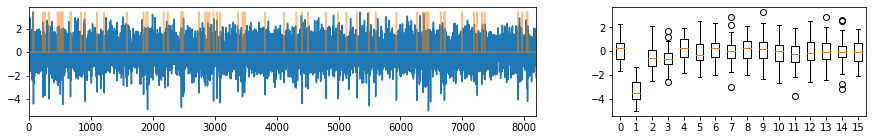

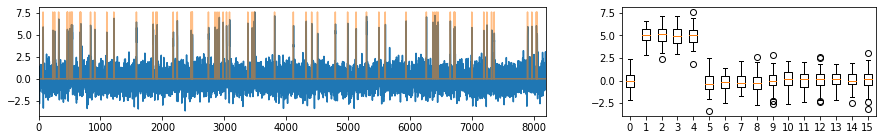

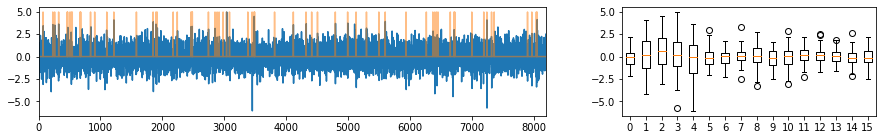

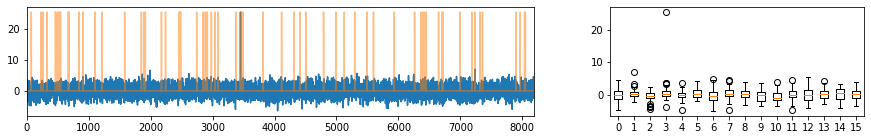

In [3]:
default_T = 8192
default_N = 64
default_q = 4

es = event_series_bernoulli(default_T, default_N)

for ts in [
    time_series_mean_impact(es, order=default_q, signal_to_noise=10.),
    time_series_meanconst_impact(es, order=default_q, const=5.),
    time_series_var_impact(es, order=default_q, variance=4.),
    time_series_tail_impact(es, order=default_q, dof=3.),
]:
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(15, 2))
    ax1.plot(ts)
    ax1.plot(es*np.max(ts), alpha=0.5)
    ax1.set_xlim(0, len(es))
    samples = eitest.obtain_samples(es, ts, method='eager', lag_cutoff=15, instantaneous=True)
    eitest.plot_samples(samples, ax2)
    plt.show()

# Simulations

In [4]:
def test_simul_pairs(impact_model, param_T, param_N, param_q, param_r,
                     n_pairs, lag_cutoff, instantaneous, sample_method,
                     twosamp_test, multi_test, alpha):
    true_positive = 0.
    false_positive = 0.
    for _ in tqdm(range(n_pairs)):
        es = event_series_bernoulli(param_T, param_N)
        if impact_model == 'mean':
            ts = time_series_mean_impact(es, param_q, param_r)
        elif impact_model == 'meanconst':
            ts = time_series_meanconst_impact(es, param_q, param_r)
        elif impact_model == 'var':
            ts = time_series_var_impact(es, param_q, param_r)
        elif impact_model == 'tail':
            ts = time_series_tail_impact(es, param_q, param_r)
        else:
            raise ValueError('impact_model must be "mean", "meanconst", "var" or "tail"')

        # coupled pair
        samples = eitest.obtain_samples(es, ts, lag_cutoff=lag_cutoff,
                                        method=sample_method,
                                        instantaneous=instantaneous,
                                        sort=(twosamp_test == 'ks')) # samples need to be sorted for K-S test
        tstats, pvals = eitest.pairwise_twosample_tests(samples, twosamp_test, min_pts=2)
        pvals_adj = eitest.multitest(np.sort(pvals[~np.isnan(pvals)]), multi_test)
        true_positive += (pvals_adj.min() < alpha)

        # uncoupled pair
        samples = eitest.obtain_samples(np.random.permutation(es), ts, lag_cutoff=lag_cutoff,
                                        method=sample_method,
                                        instantaneous=instantaneous,
                                        sort=(twosamp_test == 'ks'))
        tstats, pvals = eitest.pairwise_twosample_tests(samples, twosamp_test, min_pts=2)
        pvals_adj = eitest.multitest(np.sort(pvals[~np.isnan(pvals)]), multi_test)
        false_positive += (pvals_adj.min() < alpha)
        
    return true_positive/n_pairs, false_positive/n_pairs

In [5]:
# global parameters

default_T = 8192
n_pairs = 100
alpha = 0.05
twosamp_test = 'ks'
multi_test = 'simes'
sample_method = 'lazy'
lag_cutoff = 32
instantaneous = True

## Mean impact model

In [6]:
default_N = 64
default_r = 1.
default_q = 4

### ... by number of events

100%|██████████| 100/100 [00:04<00:00, 23.53it/s]


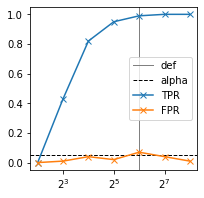

# mean impact model (T=8192, q=4, r=1.0, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# N	tpr	fpr
4	0.0	0.0
8	0.43	0.01
16	0.82	0.04
32	0.95	0.02
64	0.99	0.07
128	1.0	0.04
256	1.0	0.01



In [7]:
vals = [4, 8, 16, 32, 64, 128, 256]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='mean', param_T=default_T,
                                        param_N=val, param_q=default_q, param_r=default_r,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_N, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# mean impact model (T={default_T}, q={default_q}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# N\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

### ... by impact order

100%|██████████| 100/100 [00:00<00:00, 111.68it/s]


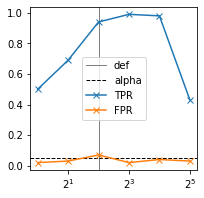

# var impact model (T=8192, N=64, r=8.0, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# q	tpr	fpr
1	0.5	0.02
2	0.69	0.03
4	0.94	0.07
8	0.99	0.02
16	0.98	0.04
32	0.43	0.03



In [48]:
vals = [1, 2, 4, 8, 16, 32]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='var', param_T=default_T,
                                        param_N=default_N, param_q=val, param_r=default_r,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_q, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# var impact model (T={default_T}, N={default_N}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# q\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

### ... by impact order

100%|██████████| 100/100 [00:00<00:00, 119.27it/s]


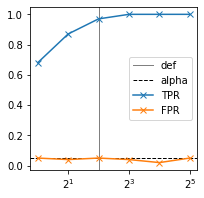

# mean impact model (T=8192, N=64, r=1.0, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# q	tpr	fpr
1	0.68	0.05
2	0.87	0.04
4	0.97	0.05
8	1.0	0.04
16	1.0	0.02
32	1.0	0.05



In [25]:
vals = [1, 2, 4, 8, 16, 32]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='mean', param_T=default_T,
                                        param_N=default_N, param_q=val, param_r=default_r,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_q, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# mean impact model (T={default_T}, N={default_N}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# q\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

### ... by signal-to-noise ratio

100%|██████████| 100/100 [00:00<00:00, 119.09it/s]


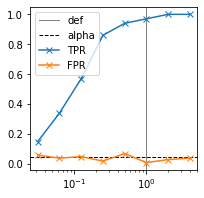

# mean impact model (T=8192, N=64, q=4, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# r	tpr	fpr
0.03125	0.15	0.06
0.0625	0.34	0.04
0.125	0.57	0.05
0.25	0.86	0.02
0.5	0.94	0.07
1.0	0.97	0.01
2.0	1.0	0.03
4.0	1.0	0.04


In [30]:
vals = [1./32, 1./16, 1./8, 1./4, 1./2, 1., 2., 4.]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='mean', param_T=default_T,
                                        param_N=default_N, param_q=default_q, param_r=val,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_r, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=10)
plt.legend()
plt.show()

print(f'# mean impact model (T={default_T}, N={default_N}, q={default_q}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# r\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')

## Meanconst impact model

In [10]:
default_N = 64
default_r = 0.5
default_q = 4

### ... by number of events

100%|██████████| 100/100 [00:04<00:00, 23.93it/s]


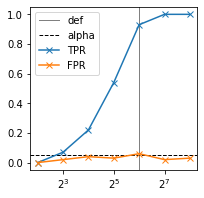

# meanconst impact model (T=8192, q=4, r=0.5, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# N	tpr	fpr
4	0.0	0.0
8	0.07	0.02
16	0.22	0.04
32	0.54	0.03
64	0.93	0.06
128	1.0	0.02
256	1.0	0.03



In [11]:
vals = [4, 8, 16, 32, 64, 128, 256]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='meanconst', param_T=default_T,
                                        param_N=val, param_q=default_q, param_r=default_r,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_N, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# meanconst impact model (T={default_T}, q={default_q}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# N\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

### ... by impact order

100%|██████████| 100/100 [00:00<00:00, 115.26it/s]


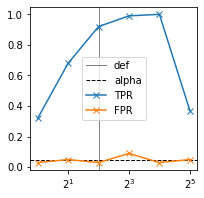

# meanconst impact model (T=8192, N=64, r=0.5, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# q	tpr	fpr
1	0.32	0.03
2	0.68	0.05
4	0.92	0.03
8	0.99	0.09
16	1.0	0.03
32	0.37	0.05



In [12]:
vals = [1, 2, 4, 8, 16, 32]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='meanconst', param_T=default_T,
                                        param_N=default_N, param_q=val, param_r=default_r,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_q, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# meanconst impact model (T={default_T}, N={default_N}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# q\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

### ... by mean value

100%|██████████| 100/100 [00:00<00:00, 116.04it/s]


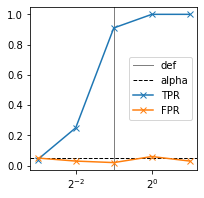

# mean impact model (T=8192, N=64, q=4, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# r	tpr	fpr
0.125	0.04	0.05
0.25	0.25	0.03
0.5	0.91	0.02
1	1.0	0.06
2	1.0	0.03



In [13]:
vals = [0.125, 0.25, 0.5, 1, 2]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='meanconst', param_T=default_T,
                                        param_N=default_N, param_q=default_q, param_r=val,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_r, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# mean impact model (T={default_T}, N={default_N}, q={default_q}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# r\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

## Variance impact model
In the paper, we show results with the variance impact model parametrized by the **variance increase**. Here we directly modulate the variance.

In [14]:
default_N = 64
default_r = 8.
default_q = 4

### ... by number of events

100%|██████████| 100/100 [00:04<00:00, 23.06it/s]


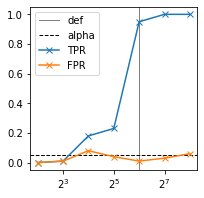

# var impact model (T=8192, q=4, r=8.0, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# N	tpr	fpr
4	0.0	0.0
8	0.01	0.01
16	0.18	0.08
32	0.23	0.04
64	0.95	0.01
128	1.0	0.03
256	1.0	0.06



In [15]:
vals = [4, 8, 16, 32, 64, 128, 256]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='var', param_T=default_T,
                                        param_N=val, param_q=default_q, param_r=default_r,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_N, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# var impact model (T={default_T}, q={default_q}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# N\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

### ... by impact order

100%|██████████| 100/100 [00:00<00:00, 122.01it/s]


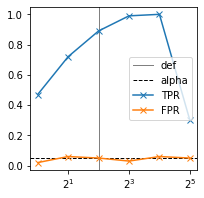

# var impact model (T=8192, N=64, r=8.0, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# q	tpr	fpr
1	0.47	0.02
2	0.72	0.06
4	0.89	0.05
8	0.99	0.03
16	1.0	0.06
32	0.3	0.05



In [16]:
vals = [1, 2, 4, 8, 16, 32]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='var', param_T=default_T,
                                        param_N=default_N, param_q=val, param_r=default_r,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_q, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# var impact model (T={default_T}, N={default_N}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# q\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

### ... by variance

100%|██████████| 100/100 [00:00<00:00, 119.65it/s]


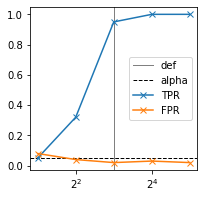

# var impact model (T=8192, N=64, q=4, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# r	tpr	fpr
2.0	0.05	0.08
4.0	0.32	0.04
8.0	0.95	0.02
16.0	1.0	0.03
32.0	1.0	0.02



In [17]:
vals = [2., 4., 8., 16., 32.]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='var', param_T=default_T,
                                        param_N=default_N, param_q=default_q, param_r=val,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_r, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# var impact model (T={default_T}, N={default_N}, q={default_q}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# r\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

## Tail impact model

In [18]:
default_N = 512
default_r = 3.
default_q = 4

### ... by number of events

100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


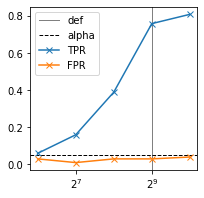

# tail impact model (T=8192, q=4, r=3.0, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# N	tpr	fpr
64	0.06	0.03
128	0.16	0.01
256	0.39	0.03
512	0.76	0.03
1024	0.81	0.04



In [19]:
vals = [64, 128, 256, 512, 1024]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='tail', param_T=default_T,
                                        param_N=val, param_q=default_q, param_r=default_r,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_N, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# tail impact model (T={default_T}, q={default_q}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# N\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

### ... by impact order

100%|██████████| 100/100 [00:10<00:00,  9.25it/s]


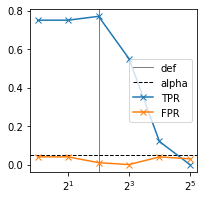

# tail impact model (T=8192, N=512, r=3.0, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# q	tpr	fpr
1	0.75	0.04
2	0.75	0.04
4	0.77	0.01
8	0.55	0.0
16	0.12	0.04
32	0.0	0.03



In [20]:
vals = [1, 2, 4, 8, 16, 32]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='tail', param_T=default_T,
                                        param_N=default_N, param_q=val, param_r=default_r,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_q, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# tail impact model (T={default_T}, N={default_N}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# q\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()

### ... by degrees of freedom

100%|██████████| 100/100 [00:10<00:00,  9.39it/s]


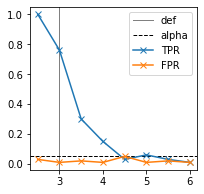

# tail impact model (T=8192, N=512, q=4, n_pairs=100, cutoff=32, instantaneous=True, alpha=0.05, lazy-ks-simes)
# r	tpr	fpr
2.5	1.0	0.03
3.0	0.76	0.01
3.5	0.3	0.02
4.0	0.15	0.01
4.5	0.03	0.05
5.0	0.06	0.01
5.5	0.03	0.02
6.0	0.01	0.01



In [21]:
vals = [2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6.]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='tail', param_T=default_T,
                                        param_N=default_N, param_q=default_q, param_r=val,
                                        n_pairs=n_pairs, sample_method=sample_method,
                                        lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.axvline(default_r, ls='-', c='gray', lw=1, label='def')
plt.axhline(alpha, ls='--', c='black', lw=1, label='alpha')
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.legend()
plt.show()

print(f'# tail impact model (T={default_T}, N={default_N}, q={default_q}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {sample_method}-{twosamp_test}-{multi_test})')
print(f'# r\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')
print()